# Project 1 TAA

In [10]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat

In [11]:
filename = "training_data_fear_neutral_happy.mat"
mat=loadmat(filename)

# mat is a dict with key "X" for x-values, and key "y" for y values
X=mat["X"]
y=mat["y"]

#number of training examples
m = len(X)
print(f"Loaded {X.shape[0]} traing examples, each with {X.shape[1]} features (pixels).")

Loaded 3000 traing examples, each with 2304 features (pixels).


### sigmoid function

In [12]:
# Add sigmoid FUNCTION from the previous lab
def sigmoid(z):
    """
    return the sigmoid of z
    """
    gz=1/(1+np.exp(-z))
    
    return gz

In [13]:
#Computes the gradient of sigmoid function
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

### LeakyRelu function and gradient

In [14]:
def leaky_relu(z):
    """
    relu activation function
    """
    return np.where(z <=0, 0.01*z, z)

In [15]:
def leaky_relu_gradient(z):
    """
    computes the gradient of the leaky relu function
    """
    return np.where(z <=0, 0.01, 1)

In [16]:
def softmax(z):
    """
    compute softmax
    """
    e_x = np.exp(z - np.max(z))
    return e_x / e_x.sum(axis=0) 

### neural network cost function

In [17]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network (regularized and non regularized)
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_cost = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_cost, grad1_reg, grad2_reg

In [59]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels,regularized=False):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        if regularized:
            cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        else:
            cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[:3]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [60]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [78]:
input_layer_size  = X.shape[1]
hidden_layer_size = 10
num_labels = max(y)[0]+1

In [100]:
# Define algorithm properties
alpha=1 #learning rate
num_iters=100
Lambda=0.1

In [80]:
# Initialize thetas
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

# Gradient descent WITHOUT regularization
nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)
Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

# Gradient descent WITH regularization
nnTheta_reg, nnJ_history_reg = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels, regularized=True)
Theta1_reg = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2_reg = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

### Analysis (Cost function by iterations)

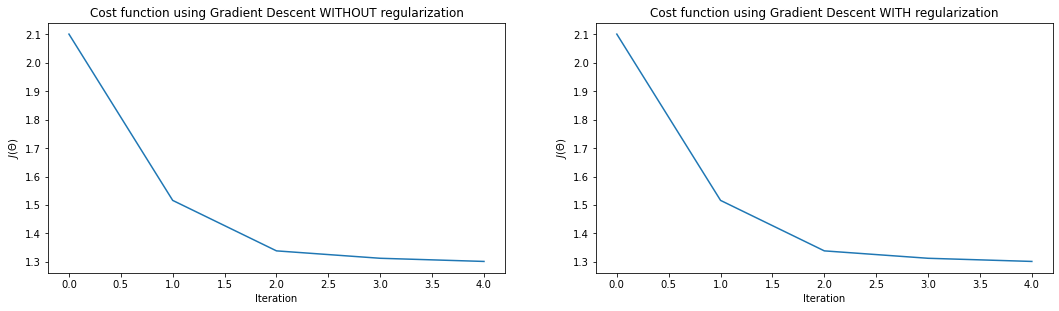

In [81]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(nnJ_history)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("$J(\Theta)$")
axs[0].set_title("Cost function using Gradient Descent WITHOUT regularization")

axs[1].plot(nnJ_history_reg)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("$J(\Theta)$")
axs[1].set_title("Cost function using Gradient Descent WITH regularization")

fig.set_size_inches(18, 4.6)

### Validation Curve (different lambda and alpha)

In [89]:
def validationCurve (X, y, Xval, yval, initial_nn_params,alpha_array, num_iter, Lambda_array,input_layer_size, hidden_layer_size, num_labels):
    """    
    Returns the best lambda and the respective train and cross validation set errors
    """
    m = len(y)
    n= X.shape[1] 
    mval = len(yval)
        
    error_train, error_val, plt_lambda, plt_alpha = [],[],[]
    
    for lam in Lambda_array:
        for a in alpha_array:
            nnTheta = gradientDescentnn( X, y,initial_nn_params,a,num_iter,lam,input_layer_size, hidden_layer_size, num_labels,regularized=True)[0]
            Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
            Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
            pred_train = predict(Theta1, Theta2, X)
            pred_val = predict(Theta1, Theta2, Xval)
            error_train_i = 1/(2*m) * np.sum((pred_train - y)**2)
            error_val_i = 1/(2*mval) * np.sum((pred_val - yval)**2)
            error_train.append(error_train_i)
            error_val.append(error_val_i)
            plt_lambda.append(lam)
            plt_alpha.append(a)
            
    
    ind = np.argmin(error_val)
    best_lambda=plt_lambda[ind]
    best_alpha =plt_alpha[ind]
    
    return best_lambda, best_alpha, error_train, error_val, plt_lambda, plt_alpha

Best alpha:0.001
Best lambda:0.001


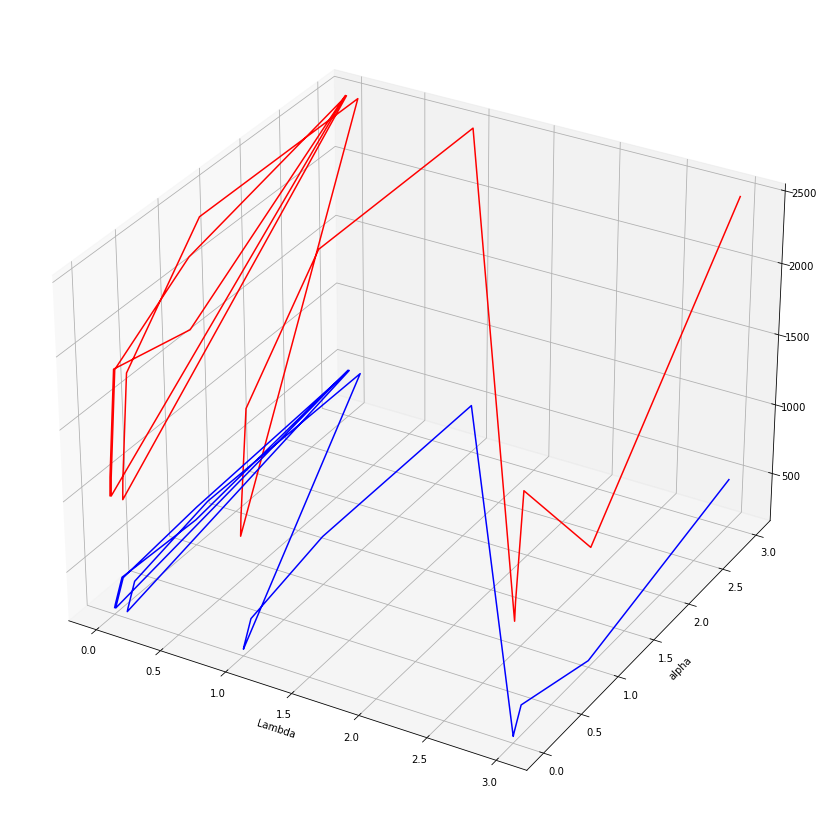

In [101]:
#Lambda_array = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

Lambda_array = [0.001,  0.01,  0.1, 1, 3]
alpha_array = [0.001,  0.01,  0.1, 1, 3]

# load dev set
mat=loadmat("dev_data_fear_neutral_happy.mat")

X_dev=mat["X"]
y_dev=mat["y"]

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

best_lambda, best_alpha, error_train, error_val, plt_lambda, plt_alpha = validationCurve(X, y, X_dev, y_dev, initial_nn_params,alpha_array, num_iters, Lambda_array,input_layer_size, hidden_layer_size, num_labels)

print("Best alpha:" + str(best_alpha) )
print("Best lambda:" + str(best_lambda) )

plot = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
plt.xlabel("Lambda")
plt.ylabel("alpha")

ax.plot3D(plt_lambda,plt_alpha,error_train, 'red')
ax.plot3D(plt_lambda,plt_alpha,error_val, 'blue')
plt.show()
#plt.plot(Lambda_array,alpha_array,error_train,label="Train")
#plt.plot(Lambda_array,alpha_array,error_val,label="Cross Validation",color="r")


#plt.legend()

### Compute accuracy

In [74]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    
    #number of training examples
    m=X.shape[0]
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m,1)), X,axis=1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1= np.dot(X,Theta1.T)
    a1= sigmoid(z1)
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)), a1,axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2= np.dot(a1,Theta2.T)
    a2= sigmoid(z2)
    
    return np.argmax(a2,axis=1)+1

In [75]:
pred2 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/m*100,"%")

pred2_reg = predict(Theta1_reg, Theta2_reg, X)
print("Training Set Accuracy (Regularized):",sum(pred2_reg[:,np.newaxis]==y)[0]/m*100,"%")

Training Set Accuracy: 34.86666666666667 %
Training Set Accuracy (Regularized): 34.86666666666667 %


### Analysis (Confusion matrix)

In [15]:
def confusionMatrix(emotions, pred, y):
    
    confusionTFPN = {}
    confusionWithOtherEmotions = {}
    
    # Foreach emotion
    for ie in range(len(emotions)):
        # TRUE AND FALSE POSITIVES AND NEGATIVES (TFPN)
        
        # Get indexes where emotion was predicted
        ieIndexesPred = [i for i in range(pred.size) if pred[i]==ie]
        ieIndexesNotPred = [i for i in range(pred.size) if pred[i]!=ie]

        # Predicted, and Actual
        TP = sum(pred[:,np.newaxis][ieIndexesPred]==y[ieIndexesPred])
        # Predicted, but not actual
        FP = sum(pred[:,np.newaxis][ieIndexesPred]!=y[ieIndexesPred])
        # Not predicted, but actual
        FN = sum(y[ieIndexesNotPred]==ie)
        # Not predicted and not actual
        TN = sum(y[ieIndexesNotPred]!=ie)

        TP = TP[0] if TP else 0
        FP = FP[0] if FP else 0
        FN = FN[0] if FN else 0
        TN = TN[0] if TN else 0
        
        confusionTFPN[emotions[ie]] = {
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN
        }
        
        # CONFUSION WITH OTHER EMOTIONS (Confusion)
        # For emotion e
        # Count the number of predictions made for all classes
        # Foreach emotion, check how many times it has been predicted 
        
        # Get indexes where emotion is real
        ieIndexesY = [i for i in range(y.size) if y[i]==ie]
        
        # Foreach matching prediction, check what emotion was predicted
        confusionWithOtherEmotions[emotions[ie]] = {
            e: sum(pred[:,np.newaxis][ieIndexesY]==emotions.index(e))[0] for e in emotions
        }
        
    return confusionTFPN, confusionWithOtherEmotions        

In [16]:
emotions = filename.split("training_data_")[1].split(".mat")[0].split("_")

# print("----------------------------\nWITHOUT regularization")
confusionTFPN, confusionWithOtherEmotions = confusionMatrix(emotions, pred2, y)

# print("\n----------------------------\nWITH regularization")
confusionTFPN_reg, confusionWithOtherEmotions_reg = confusionMatrix(emotions, pred2_reg, y)    

#### Text output

In [17]:
def outputConfusionText(emotions, y, confusionTFPN, confusionWithOtherEmotions):
    
    # OUTPUT FEEDBACK TO USER
    
    # TFPN
    print(f"\n{'Emotion':15} {'TP':8} {'%':8} {'TN':8} {'%':8} {'FP':8} {'%':8} {'FN':8} {'%':8} Total ({np.size(y)} Expected)")
    for e in emotions:
        TP = confusionTFPN[e]['TP']
        FP = confusionTFPN[e]['FP']
        FN = confusionTFPN[e]['FN']
        TN = confusionTFPN[e]['TN']
        print(f"{e:15} {TP:<8} {TP/y.size*100:<8.2f} {TN:<8} {TN/y.size*100:<8.2f} {FP:<8} {FP/y.size*100:<8.2f} {FN:<8} {FN/y.size*100:<8.2f} {FP+TP+FN+TN}")
    
    # Confusion
    print(f"\n{'True / Predicted':20}", end=" ")
    for e in emotions:
        print(f"{e:10}", end=" ")
    print()
    
    for e, others in confusionWithOtherEmotions.items():
        print(f"{e:20}", end=" ")
        for _, o in others.items():
            print(f"{o:<10}", end=" ")
        print()

In [18]:
print("WITHOUT Regularization")
outputConfusionText(emotions, y, confusionTFPN, confusionWithOtherEmotions)

print("\nWITH Regularization")
outputConfusionText(emotions, y, confusionTFPN_reg, confusionWithOtherEmotions_reg)

WITHOUT Regularization

Emotion         TP       %        TN       %        FP       %        FN       %        Total (3000 Expected)
fear            0        0.00     2000     66.67    0        0.00     1000     33.33    3000
neutral         994      33.13    14       0.47     1986     66.20    6        0.20     3000
happy           8        0.27     1988     66.27    12       0.40     992      33.07    3000

True / Predicted     fear       neutral    happy      
fear                 0          994        6          
neutral              0          994        6          
happy                0          992        8          

WITH Regularization

Emotion         TP       %        TN       %        FP       %        FN       %        Total (3000 Expected)
fear            0        0.00     2000     66.67    0        0.00     1000     33.33    3000
neutral         994      33.13    14       0.47     1986     66.20    6        0.20     3000
happy           8        0.27     1988     66.27

### Table output

In [19]:
def outputConfusionTables(emotions, y, confusionTFPN, confusionWithOtherEmotions, axs, axsLine, axsTitle):
     # TABLES
    rows = tuple(emotions)
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    
    # TABLES / TFPN
    # Output confusion matrix as plot table
    data = [
        [
            vals['TP'],
            f"{vals['TP']/y.size*100:.2f}",
            vals['TN'],
            f"{vals['TN']/y.size*100:.2f}",
            vals['FP'],
            f"{vals['FP']/y.size*100:.2f}",
            vals['FN'],
            f"{vals['FN']/y.size*100:.2f}",
            200
        ]
        for _, vals in confusionTFPN.items()
    ]
    columns = ['TP', '%', 'TN', '%', 'FP', '%', 'FN', '%', f"Total ({np.size(y)} Expected)"]
        
    the_table = axs[axsLine].table(
      cellText=data,
      rowLabels=rows,
      rowColours=colors,
      colLabels=columns,
      loc='center'
    )
    axs[axsLine].axis('off')
    axs[axsLine].axis('tight')
    axs[axsLine].set_title(f"Confusion matrix {axsTitle}")
    the_table.set_fontsize(50)
    
    
    # TABLES / Confusion    
    # Output confusion matrix as plot table
    data = [[o for _,o in others.items()] for _,others in confusionWithOtherEmotions.items()]
    columns = rows
        
    the_table = axs[axsLine+1].table(
      cellText=data,
      rowLabels=rows,
      rowColours=colors,
      colLabels=columns,
      loc='center'
    )
    axs[axsLine+1].axis('off')
    axs[axsLine+1].axis('tight')
    axs[axsLine+1].set_title(f"True/Predicted {axsTitle}")
    

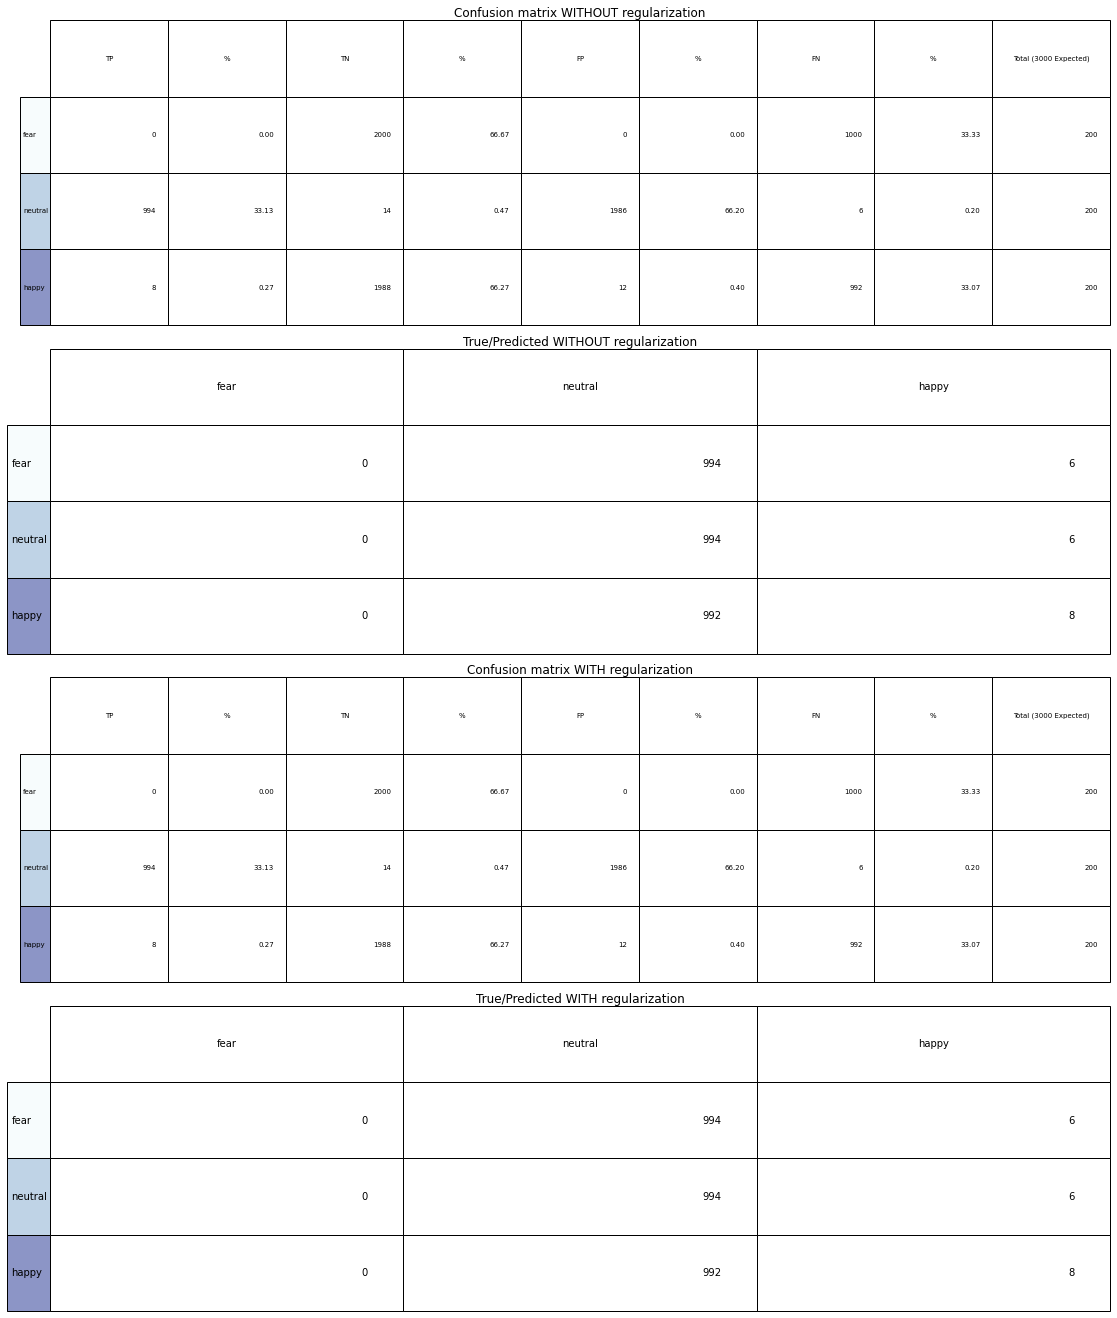

In [20]:
fig, axs = plt.subplots(4,1)
outputConfusionTables(emotions, y, confusionTFPN, confusionWithOtherEmotions, axs, 0, "WITHOUT regularization")
outputConfusionTables(emotions, y, confusionTFPN, confusionWithOtherEmotions, axs, 2, "WITH regularization")

fig.set_size_inches(18,18.4/3*len(emotions))
fig.subplots_adjust(left=0.2, top=0.8)
fig.tight_layout()